In [83]:
from os import listdir
from os.path import isfile, join

import numpy as np
from CSIKit.reader import get_reader
from CSIKit.util import csitools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
## Creating dataset without service subcarriers
### Data downloading

In [84]:
def getCsiMatrFromPcap(fileName: str, CsiFilesFolder: str) -> pd.DataFrame:
    pcapFilePath = join(CsiFilesFolder, fileName)
    my_reader = get_reader(pcapFilePath)
    csi_data = my_reader.read_file(pcapFilePath, scaled=False)
    csi_matrix, no_frames, no_subcarriers = csitools.get_CSI(csi_data, metric="amplitude")
    csi_matrix = csi_matrix[:, :, 0, 0]
    csi_matrix = pd.DataFrame(csi_matrix)
    return csi_matrix

def getCsiMatrFromCsv(fileName: str, CsiFilesFolder: str) -> pd.DataFrame:
    csvFilePath = join(CsiFilesFolder, fileName)
    return pd.read_csv(csvFilePath)

In [85]:
csi_data_folder = "CSICapturedFiles/csi_data"
csiFiles = [fileName for fileName in listdir(csi_data_folder) if isfile(join(csi_data_folder, fileName))]
csi_dict: {str: pd.DataFrame} = dict()
for fileName in csiFiles:
    csi_matrix = getCsiMatrFromPcap(fileName, csi_data_folder)
    # csi_matrix.head(2)
    csi_dict[fileName] = csi_matrix

# csi_dict
# NEXBeamformReader.read_bfee

In [86]:
csi_matrix

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,19.294189,43.772516,30.681859,31.296899,55.848071,56.700834,57.661934,58.723591,59.757121,60.629808,...,17.634280,30.644580,38.278860,32.753114,16.020600,28.692317,25.314789,26.522463,26.989700,29.329808
1,25.314789,43.772516,27.067178,24.166405,65.868901,66.382249,66.684662,66.676966,66.496607,66.162950,...,15.682017,20.969100,20.827854,31.245042,14.623980,22.576786,36.094877,27.678976,31.900514,34.189638
2,24.099331,43.772516,33.490832,15.682017,57.504012,58.695210,59.829592,60.894713,61.834612,62.585731,...,33.811151,30.170333,24.345689,32.543063,24.149733,32.977605,34.712917,29.493900,30.468852,27.986506
3,11.139434,43.772516,19.294189,20.170333,55.678119,56.724719,57.716286,58.990853,60.066256,60.983945,...,24.149733,22.504200,31.316187,20.253059,31.411361,32.753114,34.398062,27.032914,31.705551,27.067178
4,12.304489,43.772516,35.020172,32.685780,66.347934,66.872437,67.141367,67.105500,66.928755,66.638757,...,26.273659,35.959369,32.148438,32.477278,30.884905,31.809856,25.954962,29.661417,28.992732,33.106933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,19.493900,43.772516,32.052044,30.406023,66.604665,67.013179,67.188805,67.090027,66.817552,66.443721,...,32.734643,30.141003,32.278867,32.258260,33.891661,31.598678,29.201233,30.480532,28.603380,28.790959
167,20.681859,43.772516,25.118834,29.329808,66.501898,66.993362,67.320176,67.289613,67.172743,66.772591,...,26.857417,39.480215,35.175917,34.149733,15.682017,27.979596,25.289167,32.753114,35.063697,22.504200
168,24.623980,43.772516,27.242759,23.979400,55.235722,56.125984,57.086129,58.088272,59.044526,59.818168,...,29.138139,30.077478,30.530784,30.588055,27.723217,21.846914,14.149733,22.878017,16.989700,18.692317
169,18.692317,43.772516,32.097830,26.190933,66.865767,67.420124,67.757520,67.805941,67.541166,67.292717,...,36.190933,31.824147,34.747988,30.305997,36.094877,34.892552,31.442628,24.099331,30.674428,31.392492


### service subcarriers extracting

I wanted
to go through all files and all packets in each file.

Then if subcarrier have value, that is greater than 75%-th quantile of values in packet, it gets one vote.

Number of all votes equals sum of number of packets in each file.

If subcarrier has more than 70% of all votes, it is a service subcarrier.

But mentor said to google indexes of service subcarriers

In [87]:
# service subcarriers
trashSubcarriers = np.array([0, 1] + list(range(123, 134))+ [255])

In [88]:
print("service subcarriers:", trashSubcarriers)

service subcarriers: [  0   1 123 124 125 126 127 128 129 130 131 132 133 255]


In [89]:
for fileName in csi_dict:
    csi_dict[fileName] = csi_dict[fileName].drop(columns=trashSubcarriers)

##### Walking_Perpendicular_7.pcap with service subcarriers

Text(0, 0.5, 'amplitude')

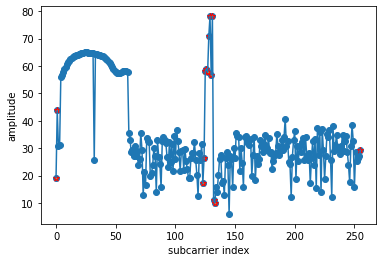

In [90]:
csi_matrix = getCsiMatrFromPcap("Walking_Perpendicular_7.pcap", csi_data_folder)
packet = csi_matrix.iloc[0]
packet.plot.line(legend=False)
plt.scatter(packet.index.values, packet.values)

plt.scatter(trashSubcarriers, packet.values[trashSubcarriers], edgecolors="red", marker="*")
plt.xlabel("subcarrier index")
plt.ylabel("amplitude")

Text(33.0, 0.5, 'subcarrier index')

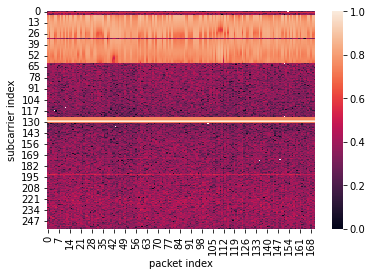

In [91]:
maxVal = csi_matrix.max().max()
csi_matrix = csi_matrix / maxVal

sns.heatmap(csi_matrix.T, vmin=0, vmax=csi_matrix.values.max())
plt.xlabel("packet index")
plt.ylabel("subcarrier index")

##### Walking_Perpendicular_7.pcap without service subcarriers

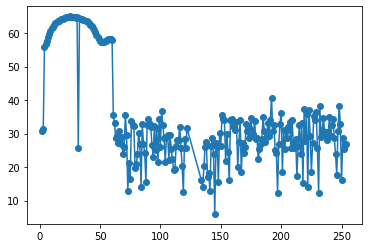

In [92]:
csi_matrix = csi_dict["Walking_Perpendicular_7.pcap"]
packet = csi_matrix.iloc[0]
packet.plot.line(legend=False)
plt.scatter(packet.index.values, packet.values)

Text(33.0, 0.5, 'subcarrier index')

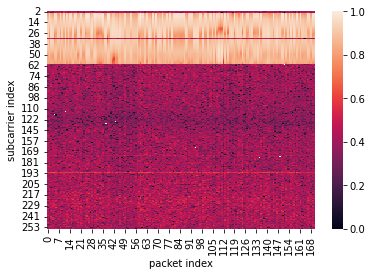

In [93]:
maxVal = csi_matrix.max().max()
csi_matrix = csi_matrix / maxVal

sns.heatmap(csi_matrix.T, vmin=0, vmax=csi_matrix.values.max())
plt.xlabel("packet index")
plt.ylabel("subcarrier index")

### uploading csi amplitude matrices into csv files

In [94]:
csi_cvs_folder = "dataset"
for fileName in csi_dict:
    csvFileName = fileName[:-4] + "csv"
    csi_dict[fileName].to_csv(join(csi_cvs_folder, csvFileName), index=False)

##### csi matrix from csv file

,2,3,4,5,6,7,8,9,10,11,...,245,246,247,248,249,250,251,252,253,254
0,30.681859,31.296899,55.848071,56.700834,57.661934,58.723591,59.757121,60.629808,61.385682,61.931538,...,23.979400,17.634280,30.644580,38.278860,32.753114,16.020600,28.692317,25.314789,26.522463,26.989700
1,27.067178,24.166405,65.868901,66.382249,66.684662,66.676966,66.496607,66.162950,65.814473,65.194942,...,28.876173,15.682017,20.969100,20.827854,31.245042,14.623980,22.576786,36.094877,27.678976,31.900514
2,33.490832,15.682017,57.504012,58.695210,59.829592,60.894713,61.834612,62.585731,63.250051,63.509989,...,33.443923,33.811151,30.170333,24.345689,32.543063,24.149733,32.977605,34.712917,29.493900,30.468852
3,19.294189,20.170333,55.678119,56.724719,57.716286,58.990853,60.066256,60.983945,61.747138,61.992861,...,20.374265,24.149733,22.504200,31.316187,20.253059,31.411361,32.753114,34.398062,27.032914,31.705551
4,35.020172,32.685780,66.347934,66.872437,67.141367,67.105500,66.928755,66.638757,66.342056,65.796319,...,17.634280,26.273659,35.959369,32.148438,32.477278,30.884905,31.809856,25.954962,29.661417,28.992732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,32.052044,30.406023,66.604665,67.013179,67.188805,67.090027,66.817552,66.443721,66.016448,65.237636,...,29.858754,32.734643,30.141003,32.278867,32.258260,33.891661,31.598678,29.201233,30.480532,28.603380
167,25.118834,29.329808,66.501898,66.993362,67.320176,67.289613,67.172743,66.772591,66.391713,65.937619,...,32.526103,26.857417,39.480215,35.175917,34.149733,15.682017,27.979596,25.289167,32.753114,35.063697
168,27.242759,23.979400,55.235722,56.125984,57.086129,58.088272,59.044526,59.818168,60.475716,61.015526,...,21.643529,29.138139,30.077478,30.530784,30.588055,27.723217,21.846914,14.149733,22.878017,16.989700
169,32.097830,26.190933,66.865767,67.420124,67.757520,67.805941,67.541166,67.292717,66.846416,66.252040,...,30.305997,36.190933,31.824147,34.747988,30.305997,36.094877,34.892552,31.442628,24.099331,30.674428


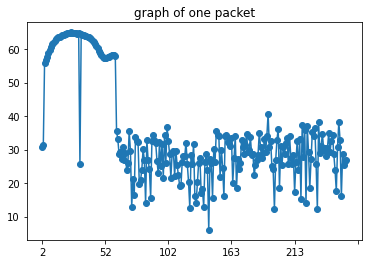

In [100]:
csi_matrix = getCsiMatrFromCsv("Walking_Perpendicular_7.csv", csi_cvs_folder)
packet = csi_matrix.iloc[0]
packet.plot.line(legend=False)
plt.scatter(packet.index.values, packet.values)
plt.title("graph of one packet")

csi_matrix

##### csi matrix from csi_dict

,2,3,4,5,6,7,8,9,10,11,...,245,246,247,248,249,250,251,252,253,254
0,30.681859,31.296899,55.848071,56.700834,57.661934,58.723591,59.757121,60.629808,61.385682,61.931538,...,23.979400,17.634280,30.644580,38.278860,32.753114,16.020600,28.692317,25.314789,26.522463,26.989700
1,27.067178,24.166405,65.868901,66.382249,66.684662,66.676966,66.496607,66.162950,65.814473,65.194942,...,28.876173,15.682017,20.969100,20.827854,31.245042,14.623980,22.576786,36.094877,27.678976,31.900514
2,33.490832,15.682017,57.504012,58.695210,59.829592,60.894713,61.834612,62.585731,63.250051,63.509989,...,33.443923,33.811151,30.170333,24.345689,32.543063,24.149733,32.977605,34.712917,29.493900,30.468852
3,19.294189,20.170333,55.678119,56.724719,57.716286,58.990853,60.066256,60.983945,61.747138,61.992861,...,20.374265,24.149733,22.504200,31.316187,20.253059,31.411361,32.753114,34.398062,27.032914,31.705551
4,35.020172,32.685780,66.347934,66.872437,67.141367,67.105500,66.928755,66.638757,66.342056,65.796319,...,17.634280,26.273659,35.959369,32.148438,32.477278,30.884905,31.809856,25.954962,29.661417,28.992732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,32.052044,30.406023,66.604665,67.013179,67.188805,67.090027,66.817552,66.443721,66.016448,65.237636,...,29.858754,32.734643,30.141003,32.278867,32.258260,33.891661,31.598678,29.201233,30.480532,28.603380
167,25.118834,29.329808,66.501898,66.993362,67.320176,67.289613,67.172743,66.772591,66.391713,65.937619,...,32.526103,26.857417,39.480215,35.175917,34.149733,15.682017,27.979596,25.289167,32.753114,35.063697
168,27.242759,23.979400,55.235722,56.125984,57.086129,58.088272,59.044526,59.818168,60.475716,61.015526,...,21.643529,29.138139,30.077478,30.530784,30.588055,27.723217,21.846914,14.149733,22.878017,16.989700
169,32.097830,26.190933,66.865767,67.420124,67.757520,67.805941,67.541166,67.292717,66.846416,66.252040,...,30.305997,36.190933,31.824147,34.747988,30.305997,36.094877,34.892552,31.442628,24.099331,30.674428


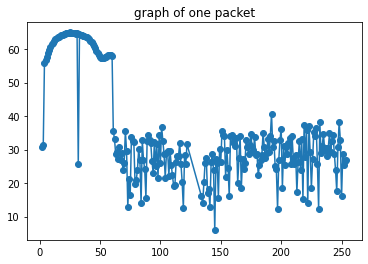

In [101]:
csi_matrix = csi_dict["Walking_Perpendicular_7.pcap"]
packet = csi_matrix.iloc[0]
packet.plot.line(legend=False)
plt.scatter(packet.index.values, packet.values)
plt.title("graph of one packet")
csi_matrix